In [266]:
#HYPERPARAMETERS - FEEL FREE TO TWEAK

DEBUG_STATEMENTS = False # feel free to change this to True and TRIALS to 1 to run a single simulation.
TRIALS = 10000000 # number of trials to run. the higher the number, the more accurate the simulation, but runs for longer.

DEBUG = False
#DEBUG = True
if (DEBUG):
    DEBUG_STATEMENTS = True
    TRIALS = 1

#PITY_ABUSE = True
PITY_THRESHOLD = 4 #how many off from guarantee pity to trigger rolling singles at pity trick.

#--------------------------------------------
# The following setting is not applicable to checking for average gem spent.

NUM_OF_STEPS = 12  # 12k gems spent is five steps, for each over step you spend 3k more.
# 9 steps is finishing box1 only. 10 steps is 27k gems, the same amount as 11-step on an arcana banner.
# 17 steps is 48k gems spent, a.k.a. the point at which spark is guaranteed.

#--------------------------------------------
# The following settings are regarding spotlight banners.

SET_1_NON_EXCELLENT_WEIGHT = 7
SET_1_NON_EXCELLENT_WEIGHT = 9001
# ^probability to get any non-excellent prize is the probability to get any excellent prize multiplied by the weight

FIRST_THREE_STEPS_NON_EXCELLENT_WEIGHT = 200 # Data evidence suggests steps 1-3 have even lower rates for excellents
FIRST_THREE_STEPS_NON_EXCELLENT_WEIGHT = 9001

SET_1_EXCELLENT_NOT_GIRL_WEIGHT = 4
SET_1_EXCELLENT_NOT_GIRL_WEIGHT = 9001
# ^probability of any non-stage-girl excellent prize is the probability to get the stage-girl prize multiplied by the weight
# if this number is 2, then each excellent prize will have equal chance to appear on the very first excellent prize roll.

SET_2_NON_EXCELLENT_WEIGHT = 7
SET_2_NON_EXCELLENT_WEIGHT = 9001
# ^probability to get any non-excellent prize is the probability to get any excellent prize multiplied by the weight

SET_2_EXCELLENT_NOT_GIRL_WEIGHT = 4
SET_2_EXCELLENT_NOT_GIRL_WEIGHT = 9001
# ^probability of any non-stage-girl excellent prize is the probability to get any stage-girl prize multiplied by the weight
# for example, if this number is 2, then - even though there are two slots for lovers,
# you still only have 33.3% chance to get Lover on the very first excellent prize roll.


In [267]:
# IMPORTS, GRAPHING, AND MISC SETUP
import random
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

bday_histo = list()
arcana_histo = list()
spotlight_histo = list()
collab_histo = list()
chopper_histo = list()

cost_buckets = list()
for i in range(50):
    cost_buckets.append(i*1500)

CURRENT_STEP = 1
PITY_COUNT = 0
SINGLES_USED = 0

def reset_trial():
    global CURRENT_STEP; global PITY_COUNT;
    CURRENT_STEP = 1
    PITY_COUNT = 0
    
def updatePityCount(rate, times):
    global PITY_COUNT
    for i in range(times):
        if random.random() <= rate:
            if DEBUG_STATEMENTS:
                print(f"Pity broken on the {i+1}-roll of {times} total rolls")
            PITY_COUNT = 0
        else:
            PITY_COUNT += 1
    if DEBUG_STATEMENTS:
        print(f"new pity count: {PITY_COUNT}")

In [268]:
STEP_TYPES = {
    'BDAY2022': {
        0:1500,
    },
    'SPOTLIGHT': {
        0: 1500,
        1: 2000,
        2: 2500,
    },
    'COLLAB': {
        0: 900,
        1: 1500,
        2: 2000,
        4: 1500,
        7: 0,
        8: 1500,
        11: 1500,
    },
    'CHOPPER': {
        0: 1500,
        1: 1500,
        3: 0,
        4: 1500,
        8: 1500,
    },
    'default': {
        6: 1500,
        9: 1500,
        4: 0,
    },
}

@lru_cache(None)
def getGemsSpent(num_steps, gacha_type):
    step_costs = STEP_TYPES.get(gacha_type, STEP_TYPES['default'])
    if num_steps > max(step_costs):
        steps = step_costs.values()
    else:
        steps = [cost for i, cost in step_costs.items()
                 if i < num_steps]
    return 3000 * (num_steps - len(steps)) + sum(steps)


In [269]:
#SPOTLIGHT GACHA DEFINITIONS

SET1 = list(); SET2 = list()
CURRENT_SET = 1

def reset_spotlight_trial():
    global CURRENT_SET; global CURRENT_STEP; global SET1; global SET2
    CURRENT_SET = 1
    CURRENT_STEP = 1
    SET1 = list(["stage girl", "excellent", "excellent", "garbage","garbage","garbage","garbage","garbage","garbage"])
    SET2 = list(["lover", "lover", "excellent", "garbage","garbage","garbage","garbage","garbage","garbage"])
    
def acquire_Excellent_Prize (pool):
    if CURRENT_SET == 1:
        if ("excellent" not in pool):
            return pool.pop(pool.index("stage girl"))
        roll_range = 1 + SET_1_EXCELLENT_NOT_GIRL_WEIGHT
        if ("stage girl" in pool and random.random() * roll_range < 1):
            return pool.pop(pool.index("stage girl"))
    else: # CURRENT_SET == 2
        if ("excellent" not in pool):
            return pool.pop(pool.index("lover"))
        roll_range = 1 + SET_2_EXCELLENT_NOT_GIRL_WEIGHT
        if (random.random() * roll_range < 1):
            return pool.pop(pool.index("lover"))
    return pool.pop(pool.index("excellent"))

def simulateOneSpotlight(): # Simulate a single step. returns True if it succeeds in getting Lovers.
    global CURRENT_SET; global CURRENT_STEP; global SET1; global SET2
    
    if DEBUG_STATEMENTS:
        print(f"step: {CURRENT_STEP}, ", end="")
    
    # first, roll the 0.2% rate gacha "normally". chance of getting 1 or more copies of lovers in one 10x pull is 1.9821%
    if random.random() < 0.019821:
        if DEBUG_STATEMENTS:
            print ("Obtained in 0.2% gacha normally")
        return True
    
    # next, roll for a spotlight prize.
    roll_range = 0
    if (CURRENT_SET == 1):
        if (CURRENT_STEP != 4):
            if (CURRENT_STEP <= 3): # steps 1-3
                roll_range = 1 + FIRST_THREE_STEPS_NON_EXCELLENT_WEIGHT
            else: #steps 5-9
                roll_range = 1 + SET_1_NON_EXCELLENT_WEIGHT
            if ("garbage" not in SET1 or random.random() * roll_range < 1):
                if acquire_Excellent_Prize(SET1) == "stage girl":
                    if (random.random() < 0.4):
                        if (DEBUG_STATEMENTS):
                            print("Obtained in box1 stage girl excellent prize")
                        return True
                    if DEBUG_STATEMENTS:
                        print("Received: OLD stage girl")
                else:
                    if DEBUG_STATEMENTS:
                        print("Received: ordinary excellent prize")
            else: # failed to get an excellent prize
                SET1.pop(SET1.index("garbage"))
                if DEBUG_STATEMENTS:
                    print("Received: garbage")
        else: # CURRENT_STEP == 4
            if acquire_Excellent_Prize(SET1) == "stage girl":
                if (random.random() < 0.4):
                    if (DEBUG_STATEMENTS):
                        print("Obtained in box1 stage girl excellent prize")
                    return True
                if DEBUG_STATEMENTS:
                    print("Received: OLD stage girl")
            else:
                if DEBUG_STATEMENTS:
                    print("Received: ordinary excellent prize")
        # check if all three excellent prizes have been acquired in SET1
        if "stage girl" not in SET1 and "excellent" not in SET1:
            if (DEBUG_STATEMENTS):
                print ("changing set to BOX 2")
            CURRENT_SET = 2

    else: # CURRENT_SET == 2
        roll_range = 1 + SET_2_NON_EXCELLENT_WEIGHT
        if ("garbage" not in SET2 or random.random() * roll_range < 1):
            if acquire_Excellent_Prize(SET2) == "lover":
                if (DEBUG_STATEMENTS):
                    print("Obtained in box2 stage girl excellent prize")
                return True
            if DEBUG_STATEMENTS:
                print("Received: ordinary excellent prize")
        else: # failed to get an excellent prize
            SET2.pop(SET2.index("garbage"))
            if DEBUG_STATEMENTS:
                print("Received: garbage")
    
    CURRENT_STEP += 1
    
    if DEBUG_STATEMENTS:
        print("WHAT'S LEFT IN BOX: ", end="")
        print(SET1) if CURRENT_SET == 1 else print(SET2)
        print()
    
    return False

In [270]:
#11-STEP TR SUPERFEST BANNER GACHA DEFINITIONS with TWO MEMO SLOTS (i.e. JUDGEMENT)
    
def simulateOneSuperfest(): # Simulate a single step. returns the num of copies the step obtained.
    global CURRENT_STEP; global PITY_COUNT; global PITY_THRESHOLD; global SINGLES_USED;
    base_rate = 0.03  #base probability for rolling any 4* stage girl
    if DEBUG_STATEMENTS:
        print(f"Starting step {CURRENT_STEP}")
    copies_obtained = 0
    if CURRENT_STEP == 3 or CURRENT_STEP == 6: #memoir takes up one slot
        for i in range(9):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
        PITY_COUNT += 1 #memo slot
    elif CURRENT_STEP == 11: #guaranteed any 4* girl
        for i in range(7):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
        if DEBUG_STATEMENTS:
            print("rolling the guaranteed 4* girl slot")
        if random.random() <= (0.007 / base_rate):
            copies_obtained += 1
            if DEBUG_STATEMENTS:
                print(f"obtained a copy in the guaranteed any 4* slot of step {CURRENT_STEP}")
        PITY_COUNT = 0
        for i in range(2):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on the post-guarantee {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
    elif CURRENT_STEP == 2: #base rate is 0.012*3
        for i in range(10):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= 0.036:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP} (3x base rate)")
            else:
                PITY_COUNT += 1
    elif CURRENT_STEP == 8: #double rate
        if DEBUG_STATEMENTS:
            print("Note: applying double-rate for featured girl")
        if PITY_ABUSE:
            if PITY_COUNT >= 70:
                if DEBUG_STATEMENTS:
                    print("pity count unbroken, eligible for step 8 pity abuse. starting 20 single rolls.")
                for i in range(20):
                    roll = random.random()
                    if roll <= 0.007:
                        copies_obtained += 1
                        PITY_COUNT = 0
                        if DEBUG_STATEMENTS:
                            print(f"obtained a copy while rolling singles. exiting pity abuse.")
                        break
                    elif roll <= base_rate:
                        PITY_COUNT = 0
                        if DEBUG_STATEMENTS:
                            print(f"spooked by random 4* while rolling singles. exiting pity abuse.")
                        break
                    else:
                        PITY_COUNT += 1
                    if i == 19:
                        if DEBUG_STATEMENTS:
                            print("successfully performed 20 singles without being spooked.")
        for i in range(10):
            roll = random.random()
            if PITY_COUNT >= 99:
                PITY_COUNT = 0
                if roll <= (0.007 * 2 / base_rate):
                    copies_obtained += 1
                    if DEBUG_STATEMENTS:
                        print(f"obtained a copy in the pity slot of step {CURRENT_STEP}")
            else:
                if roll <= (0.007 * 2):
                    copies_obtained += 1
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"obtained a copy in step {CURRENT_STEP}")
                elif roll <= base_rate:
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
                else:
                    PITY_COUNT += 1
    else: # other steps
        for i in range(10):
            roll = random.random()
            if PITY_COUNT >= 99:
                PITY_COUNT = 0
                if roll <= (0.007 / base_rate):
                    copies_obtained += 1
                    if DEBUG_STATEMENTS:
                        print(f"obtained a copy in the pity slot of step {CURRENT_STEP}")
            else:
                if roll <= 0.007:
                    copies_obtained += 1
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"obtained a copy in step {CURRENT_STEP}")
                elif roll <= base_rate:
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
                else:
                    PITY_COUNT += 1
    if DEBUG_STATEMENTS:
        print(f"Pity count at the end of step {CURRENT_STEP} is {PITY_COUNT}")
    CURRENT_STEP += 1
    return copies_obtained

In [271]:
#14-STEP COLLAB GACHA DEFINITIONS
    
def simulateOneCollab(): # Simulate a single step. returns True if it succeeds in getting.
    global CURRENT_STEP; global PITY_COUNT; global PITY_THRESHOLD; global SINGLES_USED;
    if DEBUG_STATEMENTS:
        print(f"Starting step {CURRENT_STEP}")
    if CURRENT_STEP == 7: #1.5 rate
        if random.random() < 0.1001751443194321779:
            if DEBUG_STATEMENTS:
                print("got in step 6")
            return True
    elif CURRENT_STEP == 11 or CURRENT_STEP == 14: #guaranteed any 4* girl
        PITY_COUNT = 0
        if random.random() < 0.4171:
            if DEBUG_STATEMENTS:
                print(f"got in step {CURRENT_STEP}")
            return True
    elif CURRENT_STEP == 1: # 5 rolls
        if random.random() < 0.034513418:
            if DEBUG_STATEMENTS:
                print("got in step 1")
            return True
    elif CURRENT_STEP == 4 or CURRENT_STEP == 6: #memoir takes up one slot
        if random.random() < 0.061264511581829:
            if DEBUG_STATEMENTS:
                print(f"got in step {CURRENT_STEP}")
            return True
    elif CURRENT_STEP >= 15: #double rate
        if DEBUG_STATEMENTS:
            print("Note: applying double-rate for featured girl")
        if PITY_COUNT >= 90:
            PITY_COUNT = 0
            if random.random() < 0.6335:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP} that includes PITY")
                return True
        elif PITY_COUNT >= (90 - PITY_THRESHOLD):
            for i in range(90 - PITY_COUNT):
                SINGLES_USED += 1
                if random.random() < 0.014: #currently step7 pity not implemented. this will have to be a switch if it is.
                    if DEBUG_STATEMENTS:
                        print(f"got in singles spook while attempting step {CURRENT_STEP} pity")
                    return True
                updatePityCount(0.024, 1)
                if PITY_COUNT < (90 - PITY_THRESHOLD):
                    if DEBUG_STATEMENTS:
                        print("Pity trick failed, resuming regular 10x pulls")
                    break
            if PITY_COUNT >= 90:
                PITY_COUNT = 0
                if random.random() < 0.6335:
                    if DEBUG_STATEMENTS:
                        print(f"got in PITY TRICK of step {CURRENT_STEP}")
                    return True
            else:
                if random.random() < 0.1315013466030288563:
                    if DEBUG_STATEMENTS:
                        print(f"got in step {CURRENT_STEP} (failed pity trick)")
                    return True
        else:
            if random.random() < 0.1315013466030288563:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP}")
                return True
    else: # step 2, 3, 5, 8, 9, 10, 12, 13:
        if PITY_COUNT >= 90:
            PITY_COUNT = 0
            if random.random() < 0.4171:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP} that includes PITY")
                return True
        elif PITY_COUNT >= (90 - PITY_THRESHOLD):
            for i in range(90 - PITY_COUNT):
                SINGLES_USED += 1
                if random.random() < 0.007:
                    if DEBUG_STATEMENTS:
                        print(f"got in singles spook while attempting step {CURRENT_STEP} pity")
                    return True
                updatePityCount(0.024, 1)
                if PITY_COUNT < (90 - PITY_THRESHOLD):
                    if DEBUG_STATEMENTS:
                        print("Pity trick failed, resuming regular 10x pulls")
                    break
            if PITY_COUNT >= 90:
                PITY_COUNT = 0
                if random.random() < 0.4171:
                    if DEBUG_STATEMENTS:
                        print(f"got in PITY TRICK of step {CURRENT_STEP}")
                    return True
            else:
                if random.random() < 0.06783566:
                    if DEBUG_STATEMENTS:
                        print(f"got in step {CURRENT_STEP} (failed pity trick)")
                    return True
        else:
            if random.random() < 0.06783566:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP}")
                return True
    
    if CURRENT_STEP == 3:
        updatePityCount(0.036, 10)
    elif CURRENT_STEP == 11 or CURRENT_STEP == 14:
        updatePityCount(0.024, 2)
    else:
        updatePityCount(0.024, 10)
    CURRENT_STEP += 1
    return False

In [272]:
#11-STEP MODERN CHOPPER/TR SUPPORT GACHA DEFINITIONS (e.g. ANASTASIA, BS MICHIRU)
    
def simulateOneChopper(): # Simulate a single step. returns the num of copies the step obtained.
    global CURRENT_STEP; global PITY_COUNT; global PITY_THRESHOLD; global SINGLES_USED;
    base_rate = 0.024 #base probability for rolling any 4* stage girl
    if DEBUG_STATEMENTS:
        print(f"Starting step {CURRENT_STEP}")
    copies_obtained = 0
    if CURRENT_STEP == 7: #1.5 rate AND memoir takes up one slot
        for i in range(9):
            roll = random.random()
            if roll <= (0.007 * 1.5):
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
        PITY_COUNT += 1 #memo slot
    elif CURRENT_STEP == 6 or CURRENT_STEP == 11: #guaranteed any 4* girl
        for i in range(7):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
        if DEBUG_STATEMENTS:
            print("rolling the guaranteed 4* girl slot")
        if random.random() <= (0.007 / base_rate):
            copies_obtained += 1
            if DEBUG_STATEMENTS:
                print(f"obtained a copy in the guaranteed any 4* slot of step {CURRENT_STEP}")
        PITY_COUNT = 0
        for i in range(2):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on the post-guarantee {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
    elif CURRENT_STEP == 3: #memoir takes up one slot AND base rate is 0.012*3
        for i in range(9):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= 0.036:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP} (3x base rate)")
            else:
                PITY_COUNT += 1
        PITY_COUNT += 1 #memo slot
    elif CURRENT_STEP == 8: #double rate
        if DEBUG_STATEMENTS:
            print("Note: applying double-rate for featured girl")
        for i in range(10):
            roll = random.random()
            if roll <= (0.007 * 2):
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
    else: # other steps
        for i in range(10):
            roll = random.random()
            if PITY_COUNT >= 99:
                PITY_COUNT = 0
                if roll <= (0.007 / base_rate):
                    copies_obtained += 1
                    if DEBUG_STATEMENTS:
                        print(f"obtained a copy in the pity slot of step {CURRENT_STEP}")
            else:
                if roll <= 0.007:
                    copies_obtained += 1
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"obtained a copy in step {CURRENT_STEP}")
                elif roll <= base_rate:
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
                else:
                    PITY_COUNT += 1
    if DEBUG_STATEMENTS:
        print(f"Pity count at the end of step {CURRENT_STEP} is {PITY_COUNT}")
    CURRENT_STEP += 1
    return copies_obtained

In [273]:
#12-STEP 2022 BIRTHDAY GACHA DEFINITIONS (e.g. Yuusha Hikari, Yellow Tsukasa)
    
def simulateOneBday(): # Simulate a single step. returns the num of copies the step obtained.
    global CURRENT_STEP; global PITY_COUNT; global PITY_THRESHOLD; global SINGLES_USED;
    base_rate = 0.024 #base probability for rolling any 4* stage girl
    if DEBUG_STATEMENTS:
        print(f"Starting step {CURRENT_STEP}")
    copies_obtained = 0
    if CURRENT_STEP == 8 or CURRENT_STEP == 12: #guaranteed a 4* girl
        for i in range(7):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
        if DEBUG_STATEMENTS:
            print("rolling the guaranteed 4* girl slot")
        if random.random() <= (0.007 / base_rate):
            copies_obtained += 1
            if DEBUG_STATEMENTS:
                print(f"obtained a copy in the guaranteed any 4* slot of step {CURRENT_STEP}")
        PITY_COUNT = 0
        for i in range(2):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on the post-guarantee {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
    elif CURRENT_STEP == 2 or CURRENT_STEP == 4: #base rate is 0.012*3 and 0.012*4 respectively
        for i in range(10):
            roll = random.random()
            if roll <= 0.007:
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            if CURRENT_STEP == 2:
                if roll <= 0.036:
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP} (3x base rate)")
                else:
                    PITY_COUNT += 1
            else: #CURRENT_STEP == 4:
                if roll <= 0.048:
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP} (4x base rate)")
                else:
                    PITY_COUNT += 1
    elif CURRENT_STEP == 6 or CURRENT_STEP == 11: #1.5 rate
        for i in range(10):
            roll = random.random()
            if roll <= (0.007 * 1.5):
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
    elif CURRENT_STEP == 7: #double rate
        if DEBUG_STATEMENTS:
            print("Note: applying double-rate for featured girl")
        for i in range(10):
            roll = random.random()
            if roll <= (0.007 * 2):
                copies_obtained += 1
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"obtained a copy in step {CURRENT_STEP}")
            elif roll <= base_rate:
                PITY_COUNT = 0
                if DEBUG_STATEMENTS:
                    print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
            else:
                PITY_COUNT += 1
    else: # other steps
        for i in range(10):
            roll = random.random()
            if PITY_COUNT >= 99:
                PITY_COUNT = 0
                if roll <= (0.007 / base_rate):
                    copies_obtained += 1
                    if DEBUG_STATEMENTS:
                        print(f"obtained a copy in the pity slot of step {CURRENT_STEP}")
            else:
                if roll <= 0.007:
                    copies_obtained += 1
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"obtained a copy in step {CURRENT_STEP}")
                elif roll <= base_rate:
                    PITY_COUNT = 0
                    if DEBUG_STATEMENTS:
                        print(f"Pity count broken on {i+1}-roll of step {CURRENT_STEP}")
                else:
                    PITY_COUNT += 1
    if DEBUG_STATEMENTS:
        print(f"Pity count at the end of step {CURRENT_STEP} is {PITY_COUNT}")
    CURRENT_STEP += 1
    return copies_obtained

In [274]:
# RUN TRIALS
histogram = list()
total_copies_obtained = 0
for i in range(TRIALS):
    reset_trial()
    for i in range(12):
        total_copies_obtained += simulateOneBday()
    histogram.append(total_copies_obtained)
    if(DEBUG_STATEMENTS):
        print(f"total copies obtained this trial is {total_copies_obtained}")
    total_copies_obtained = 0

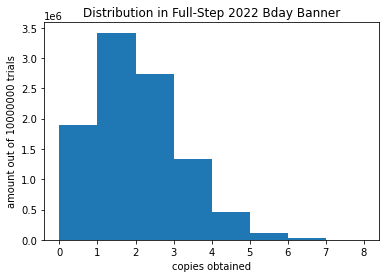

In [281]:
# PDF FOR COPIES OBTAINED
cost_buckets = list()
for i in range(9):
    cost_buckets.append(i)
    
fig,ax = plt.subplots(1,1)
ax.hist(histogram, cost_buckets)

#x_major_ticks = np.arange(0, 10, 1)
#ax.set_xticks(x_major_ticks)

ax.set_title("Distribution in Full-Step 2022 Bday Banner")
ax.set_xlabel('copies obtained')
ax.set_ylabel('amount out of ' + str(TRIALS) + ' trials')
plt.show()

In [282]:
# SHOW CONCRETE NUMBERS

amount_in_bin = list()
for i in range(9):
    amount_in_bin.append(0)
amount_in_bin_percentage = list(amount_in_bin)

for i in range(len(histogram)):
    for j in range(len(amount_in_bin)):
        if histogram[i] == j:
            amount_in_bin[j] += 1
            
print(amount_in_bin)

for i in range(len(amount_in_bin)):
    amount_in_bin_percentage[i] = amount_in_bin[i] / TRIALS * 100
    
print(amount_in_bin_percentage)

[1901885, 3418741, 2742474, 1336010, 454914, 117342, 23830, 4151, 582]
[19.01885, 34.18741, 27.424739999999996, 13.3601, 4.54914, 1.1734200000000001, 0.2383, 0.04151, 0.00582]


In [24]:
# RUN TRIALS: SPOTLIGHT

spotlight_cumulative_gem_spent = 0
steps_used = 0

for i in range(TRIALS):
    reset_trial()
    while True:
        steps_used += 1
        if simulateOneSpotlight() == True:
            gemsForThisTrial = getGemsSpent(steps_used, "SPOTLIGHT")
            spotlight_cumulative_gem_spent += gemsForThisTrial
            spotlight_histo.append(gemsForThisTrial)
            steps_used = 0
            break

average_spotlight_spent = spotlight_cumulative_gem_spent / TRIALS

print()
print(f"AFTER RUNNING {TRIALS} TRIALS,")
print(f"Experimentally determined avg gem spent to get the girl on a spotlight banner is {average_spotlight_spent}")


AFTER RUNNING 1000000 TRIALS,
Experimentally determined avg gem spent to get the girl on a spotlight banner is 33211.2785


In [14]:
# RUN TRIALS: TR SUPERFEST

superfest_cumulative_gem_spent = 0
steps_used = 0
cumulative_singles_used = 0

for i in range(TRIALS):
    reset_trial()
    while True:
        steps_used += 1
        if simulateOneSuperfest() == True:
            gemsForThisTrial = getGemsSpent(steps_used, "SUPERFEST")
            gemsForThisTrial += SINGLES_USED * 300
            cumulative_singles_used += SINGLES_USED
            SINGLES_USED = 0
            arcana_histo.append(gemsForThisTrial)
            superfest_cumulative_gem_spent += gemsForThisTrial
            steps_used = 0
            break

print(f"single pulls used: {cumulative_singles_used}")
superfest_cumulative_gem_spent += cumulative_singles_used * 300
average_superfest_spent = superfest_cumulative_gem_spent / TRIALS

print(f"AFTER RUNNING {TRIALS} TRIALS,")
print(f"Experimentally determined avg gem spent to get the girl on the TR superfest banner is {average_superfest_spent}")

single pulls used: 862754
AFTER RUNNING 1000000 TRIALS,
Experimentally determined avg gem spent to get the girl on the TR superfest banner is 29653.4739


In [33]:
# RUN TRIALS: 14-STEP COLLAB

collab_cumulative_gem_spent = 0
steps_used = 0
cumulative_singles_used = 0

for i in range(TRIALS):
    reset_trial()
    while True:
        steps_used += 1
        if simulateOneCollab() == True:
            gemsForThisTrial = getGemsSpent(steps_used, "COLLAB")
            gemsForThisTrial += SINGLES_USED * 300
            cumulative_singles_used += SINGLES_USED
            SINGLES_USED = 0
            collab_histo.append(gemsForThisTrial)
            collab_cumulative_gem_spent += gemsForThisTrial
            steps_used = 0
            break

print(f"single pulls used: {cumulative_singles_used}")
collab_cumulative_gem_spent += cumulative_singles_used * 300
average_collab_spent = collab_cumulative_gem_spent / TRIALS

print(f"AFTER RUNNING {TRIALS} TRIALS,")
print(f"Experimentally determined avg gem spent to get the girl on the 14-step collab banner is {average_collab_spent}")

single pulls used: 6120
AFTER RUNNING 100000 TRIALS,
Experimentally determined avg gem spent to get the girl on the 14-step collab banner is 20804.56


In [23]:
# RUN TRIALS: 11-STEP CHOPPER

chopper_cumulative_gem_spent = 0
steps_used = 0
cumulative_singles_used = 0

for i in range(TRIALS):
    reset_trial()
    while True:
        steps_used += 1
        if simulateOneChopper() == True:
            gemsForThisTrial = getGemsSpent(steps_used, "CHOPPER")
            gemsForThisTrial += SINGLES_USED * 300
            cumulative_singles_used += SINGLES_USED
            SINGLES_USED = 0
            chopper_histo.append(gemsForThisTrial)
            chopper_cumulative_gem_spent += gemsForThisTrial
            steps_used = 0
            break

print(f"single pulls used: {cumulative_singles_used}")
chopper_cumulative_gem_spent += cumulative_singles_used * 300
average_chopper_spent = chopper_cumulative_gem_spent / TRIALS

print(f"AFTER RUNNING {TRIALS} TRIALS,")
print(f"Experimentally determined avg gem spent to get the girl on the 11-step BS chopper banner is {average_chopper_spent}")

single pulls used: 62895
AFTER RUNNING 1000000 TRIALS,
Experimentally determined avg gem spent to get the girl on the 11-step BS chopper banner is 19473.234


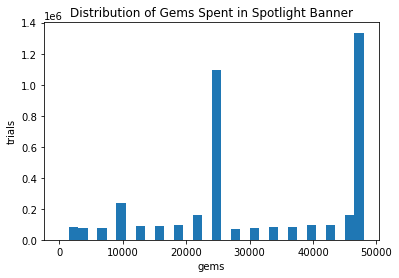

In [25]:
# PDF for SPOTLIGHT

cost_buckets = list()
for i in range(33):
    cost_buckets.append(i*1500)

fig,ax = plt.subplots(1,1)
ax.hist(spotlight_histo, cost_buckets)
ax.set_title("Distribution of Gems Spent in Spotlight Banner")
ax.set_xlabel('gems')
ax.set_ylabel('trials')
plt.show()

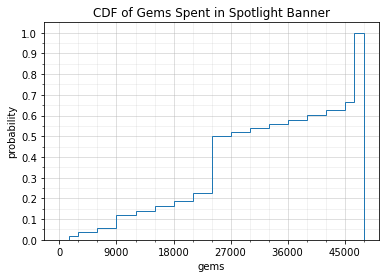

In [27]:
# CDF for Spotlight

fig,ax = plt.subplots(1,1)
ax.hist(spotlight_histo, cost_buckets, density=True, histtype='step', cumulative=True)
# Major ticks every 20, minor ticks every 5
y_major_ticks = np.arange(0, 1.1, 0.1)
y_minor_ticks = np.arange(0, 1.0, 0.05)

x_major_ticks = np.arange(0, 50000, 9000)
x_minor_ticks = np.arange(0, 50000, 3000)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title("CDF of Gems Spent in Spotlight Banner")
ax.set_xlabel('gems')
ax.set_ylabel('probability')
plt.show()

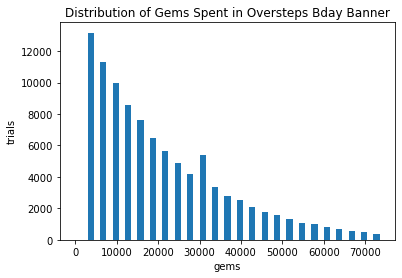

In [31]:
# PDF for Bday

fig,ax = plt.subplots(1,1)
ax.hist(bday_histo, cost_buckets)
ax.set_title("Distribution of Gems Spent in Oversteps Bday Banner")
ax.set_xlabel('gems')
ax.set_ylabel('trials')
plt.show()

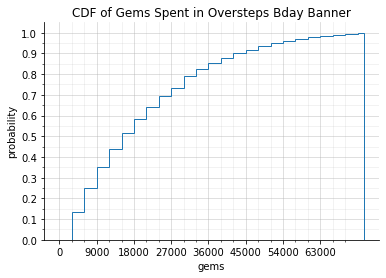

In [41]:
# CDF for Bday

fig,ax = plt.subplots(1,1)
ax.hist(bday_histo, cost_buckets, density=True, histtype='step', cumulative=True)
# Major ticks every 20, minor ticks every 5
y_major_ticks = np.arange(0, 1.1, 0.1)
y_minor_ticks = np.arange(0, 1.0, 0.05)

x_major_ticks = np.arange(0, 70000, 9000)
x_minor_ticks = np.arange(0, 70000, 3000)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("CDF of Gems Spent in Oversteps Bday Banner")
ax.set_xlabel('gems')
ax.set_ylabel('probability')
plt.show()

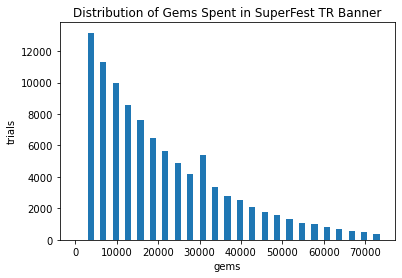

In [33]:
# PDF for 

#cost_buckets = list()
#for i in range(130):
#    cost_buckets.append(i*1500)

fig,ax = plt.subplots(1,1)
ax.hist(arcana_histo, cost_buckets)
ax.set_title("Distribution of Gems Spent in SuperFest TR Banner")
ax.set_xlabel('gems')
ax.set_ylabel('trials')
plt.show()

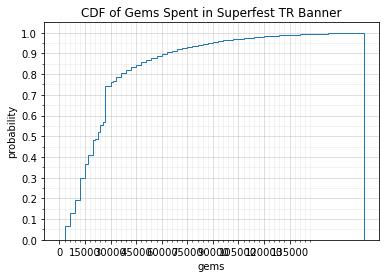

In [37]:
fig,ax = plt.subplots(1,1)
ax.hist(arcana_histo, cost_buckets, density=True, histtype='step', cumulative=True)
# Major ticks every 20, minor ticks every 5
y_major_ticks = np.arange(0, 1.1, 0.1)
y_minor_ticks = np.arange(0, 1.0, 0.05)

x_major_ticks = np.arange(0, 150000, 15000)
x_minor_ticks = np.arange(0, 150000, 3000)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title("CDF of Gems Spent in Superfest TR Banner")
ax.set_xlabel('gems')
ax.set_ylabel('probability')
plt.show()

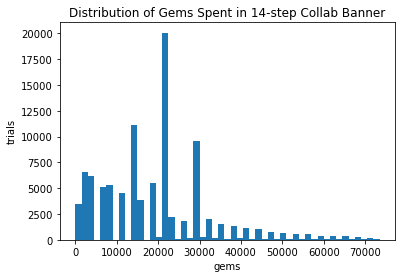

In [36]:
fig,ax = plt.subplots(1,1)

ax.hist(collab_histo, cost_buckets)
ax.set_title("Distribution of Gems Spent in 14-step Collab Banner")
ax.set_xlabel('gems')
ax.set_ylabel('trials')
plt.show()

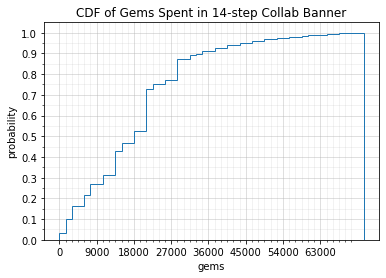

In [25]:
fig,ax = plt.subplots(1,1)
ax.hist(collab_histo, cost_buckets, density=True, histtype='step', cumulative=True)
# Major ticks every 20, minor ticks every 5
y_major_ticks = np.arange(0, 1.1, 0.1)
y_minor_ticks = np.arange(0, 1.0, 0.05)

x_major_ticks = np.arange(0, 72000, 9000)
x_minor_ticks = np.arange(0, 72000, 1500)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title("CDF of Gems Spent in 14-step Collab Banner")
ax.set_xlabel('gems')
ax.set_ylabel('probability')
plt.show()

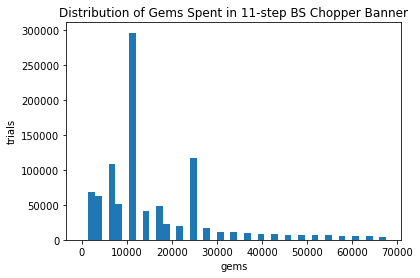

In [28]:
cost_buckets = list()
for i in range(46):
    cost_buckets.append(i*1500)

fig,ax = plt.subplots(1,1)

ax.hist(chopper_histo, cost_buckets)
ax.set_title("Distribution of Gems Spent in 11-step BS Chopper Banner")
ax.set_xlabel('gems')
ax.set_ylabel('trials')
plt.show()

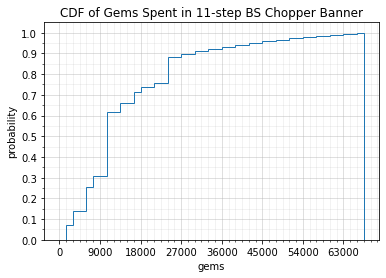

In [29]:
fig,ax = plt.subplots(1,1)
ax.hist(chopper_histo, cost_buckets, density=True, histtype='step', cumulative=True)
# Major ticks every 20, minor ticks every 5
y_major_ticks = np.arange(0, 1.1, 0.1)
y_minor_ticks = np.arange(0, 1.0, 0.05)

x_major_ticks = np.arange(0, 72000, 9000)
x_minor_ticks = np.arange(0, 72000, 1500)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title("CDF of Gems Spent in 11-step BS Chopper Banner")
ax.set_xlabel('gems')
ax.set_ylabel('probability')
plt.show()

In [72]:
# RUN THIS CELL FOR DETERMINING CHANCE OF GETTING IN SPOTLIGHT

success = 0

for i in range(TRIALS):
    reset_spotlight_trial()
    if DEBUG_STATEMENTS:
        print("NEW TRIAL STARTED. FRESH BOX1 CONTENTS:")
        print(SET1)
        print()
    
    for j in range(NUM_OF_STEPS):
        if simulateOneSpotlight() == True:
            success += 1
            break

Chance_at_getting = success / TRIALS * 100
print()
print(f"AFTER RUNNING {TRIALS} TRIALS WITH {NUM_OF_STEPS} STEPS EACH,")
print(f"The simulated probability of getting Lover is {Chance_at_getting}%")

NEW TRIAL STARTED. FRESH BOX1 CONTENTS:
['stage girl', 'excellent', 'excellent', 'garbage', 'garbage', 'garbage', 'garbage', 'garbage', 'garbage']

step: 1, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'excellent', 'garbage', 'garbage', 'garbage', 'garbage', 'garbage']

step: 2, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'excellent', 'garbage', 'garbage', 'garbage', 'garbage']

step: 3, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'excellent', 'garbage', 'garbage', 'garbage']

step: 4, Received: ordinary excellent prize
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'garbage', 'garbage', 'garbage']

step: 5, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'garbage', 'garbage']

step: 6, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'garbage']

step: 7, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent']

step: 8, Received: ordinary excellent prize
WHAT'S LEFT IN BOX: ['